In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from src.model.eegnet_variance import EEGNetMultiHeaded
from pytorch_lightning.loggers import CometLogger
from src.datamodule import DataModule, predictDataSet
from src.preprocessing import create_dataset
import pytorch_lightning as pl
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from src.preprocessing import *
import copy
import pickle


In [3]:
# Load training module
# The preproccesing code is currently quite messy, still need to clean it up
train, val, test = create_dataset('./src/pickle_df', 1)


In [4]:
comet_logger = CometLogger(
    api_key="WSATCNWE43zphHslQCTsJKcgk",
    workspace="marwo22",  # Optional
    project_name="bachelors-project"  # Optional
)

CometLogger will be initialized in online mode


In [6]:
# 0% shuffle to 100% shuffled, at 10% intervals

if os.path.isfile('results_pickled/checkpoints/shuffle.pkl'):
    with open('results_pickled/checkpoints/shuffle.pkl', 'rb') as f:
        progress = pickle.load(f)

    with open('results_pickled/shuffle.pkl', 'rb') as f:
        variances = pickle.load(f)

    print(progress)
else:
    progress = 0
    variances = [[] for _ in range(11)]

while progress < 6:

    for i in range(11):
        # Not sure if deep copies are even needed
        train_copy = copy.deepcopy(train)

        # Take sublist of the percentage we want to shuffle, shuffle the sublist, and then insert back into main list
        n_shuffle = int(len(train_copy[1]) / 10 * i)
        to_shuffle = train_copy[1][:n_shuffle]
        random.shuffle(to_shuffle)
        train_copy[1][:n_shuffle] = to_shuffle


        dm = DataModule(train=train_copy, val=val, test=test, batch_size=16)

        model = EEGNetMultiHeaded(chunk_size=308,
                                num_electrodes=64,
                                dropout=0.5,
                                kernel_1=64,
                                kernel_2=16,
                                F1=8,
                                F2=16,
                                D=2,
                                num_classes=2)

        trainer = pl.Trainer(
            max_epochs=25,
            logger=comet_logger
        )

        trainer.fit(model, datamodule=dm)

        test_results = trainer.test(model, datamodule=dm)
            
        # Capture the testing variance and accuracy
        variances[i].append(test_results[0]['overall_var'])

    progress += 1
    with open('results_pickled/shuffle.pkl', 'wb') as f:
        pickle.dump(variances, f)

    with open('results_pickled/checkpoints/shuffle.pkl', 'wb') as f:
        pickle.dump(progress, f)
    
    with open('results_pickled/results_sets/shuffle_' + str(progress) + '.pkl', 'wb') as f:
        pickle.dump([train, val, test], f)



    

6


: 

Text(0, 0.5, 'Variance')

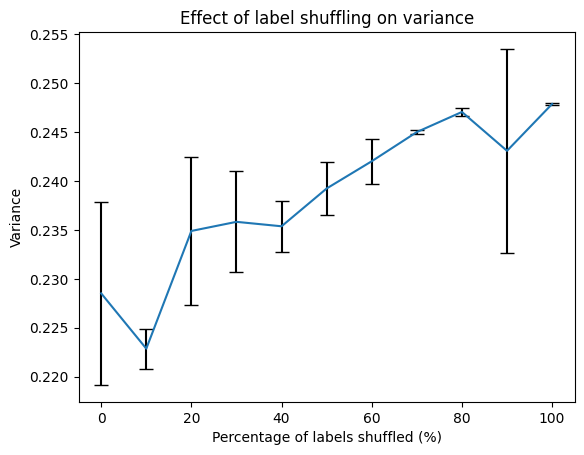

In [7]:
# Load in the .pkl files
with open('results_pickled/shuffle.pkl', 'rb') as f:
    variances = pickle.load(f)

standard_deviation = []

t = np.asarray([0, 10, 20, 30, 40, 50, 60, 70 ,80, 90, 100])

for i in range(11):
    standard_deviation.append(np.asarray(variances[i]).std())
    variances[i] = np.asarray(variances[i]).mean()

plt.errorbar(t, variances, yerr=standard_deviation, capsize=5, ecolor='k')
plt.title("Effect of label shuffling on variance")
plt.xlabel("Percentage of labels shuffled (%)")
plt.ylabel("Variance")

